In [8]:
# BLOQUE 1 (Sprint 1)
# Montar Drive + validar datasets + rutas

from google.colab import drive
drive.mount("/content/drive")

import os
import pandas as pd
import numpy as np

# Ruta base corregida según tu carpeta real
RUTA_BASE = "./data/"

# Archivos esperados según tu Drive y tu código
expected_files = [
    "olist_customers_dataset.csv",
    "olist_geolocation_dataset.csv",
    "olist_order_items_dataset.csv",
    "olist_order_payments_dataset.csv",
    "olist_order_reviews_dataset.csv",
    "olist_orders_dataset.csv",
    "olist_products_dataset.csv",
    "olist_sellers_dataset.csv",
    "product_category_name_translation.csv"
]

print("Archivos encontrados en la carpeta Scrum:")
found_files = os.listdir(RUTA_BASE)
print(found_files)

# Validación de existencia
missing = [f for f in expected_files if f not in found_files]

if len(missing) == 0:
    print("\nTodos los datasets requeridos están en Drive.")
else:
    print("\nFaltan estos archivos en la carpeta Scrum:")
    for f in missing:
        print(" -", f)

# Diccionario de rutas (para usar directo en Bloque 2)
FILES = {f: os.path.join(RUTA_BASE, f) for f in expected_files}

print("\nDiccionario FILES creado. Ejemplo:")
for k in list(FILES.keys())[:3]:
    print(k, "->", FILES[k])



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archivos encontrados en la carpeta Scrum:
['modelo_final_xgb.pkl', 'product_category_name_translation.csv', 'Copia de Sprint3.ipynb', 'olist_sellers_dataset.csv', 'figuras_sprint3', 'olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_products_dataset.csv', 'olist_order_reviews_dataset.csv', 'orders_extended_master.csv']

Todos los datasets requeridos están en Drive.

Diccionario FILES creado. Ejemplo:
olist_customers_dataset.csv -> ./data/olist_customers_dataset.csv
olist_geolocation_dataset.csv -> ./data/olist_geolocation_dataset.csv
olist_order_items_dataset.csv -> ./data/olist_order_items_dataset.csv


In [9]:
# BLOQUE 2 (Sprint 1)
# Cargar tablas desde FILES + parsear fechas

# Cargar datasets principales
customers = pd.read_csv(FILES["olist_customers_dataset.csv"])
geo = pd.read_csv(FILES["olist_geolocation_dataset.csv"])
order_items = pd.read_csv(FILES["olist_order_items_dataset.csv"])
order_payments = pd.read_csv(FILES["olist_order_payments_dataset.csv"])
reviews = pd.read_csv(FILES["olist_order_reviews_dataset.csv"])
products = pd.read_csv(FILES["olist_products_dataset.csv"])
sellers = pd.read_csv(FILES["olist_sellers_dataset.csv"])
cat_trad = pd.read_csv(FILES["product_category_name_translation.csv"])

# Cargar orders con parseo de fechas
orders = pd.read_csv(
    FILES["olist_orders_dataset.csv"],
    parse_dates=[
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
    ],
    dayfirst=False,
    infer_datetime_format=True
)

print("Shapes de tablas cargadas:")
print("- customers:", customers.shape)
print("- geo:", geo.shape)
print("- order_items:", order_items.shape)
print("- order_payments:", order_payments.shape)
print("- reviews:", reviews.shape)
print("- orders:", orders.shape)
print("- products:", products.shape)
print("- sellers:", sellers.shape)
print("- cat_trad:", cat_trad.shape)

print("\nColumnas de orders:")
print(orders.columns.tolist())

print("\nEstado de las fechas en orders:")
print(orders[[
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]].dtypes)


/tmp/ipython-input-3221159311.py:15: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  orders = pd.read_csv(


Shapes de tablas cargadas:
- customers: (99441, 5)
- geo: (1000163, 5)
- order_items: (112650, 7)
- order_payments: (103886, 5)
- reviews: (99224, 7)
- orders: (99441, 8)
- products: (32951, 9)
- sellers: (3095, 4)
- cat_trad: (71, 2)

Columnas de orders:
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

Estado de las fechas en orders:
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object


In [10]:
# BLOQUE 3 (Sprint 1)
# Crear target estricto y extendido

# 1) Target estricto: solo estado 'canceled'
orders["is_canceled_strict"] = (orders["order_status"] == "canceled").astype(int)

# 2) Componentes del target extendido

# 2.1 Cancelado explícito
cond_canceled = orders["order_status"] == "canceled"

# 2.2 Unavailable (pedido no completado por stock/pago)
cond_unavailable = orders["order_status"] == "unavailable"

# 2.3 Pedidos "colgados": created / processing sin entrega después de 30 días
last_purchase = orders["order_purchase_timestamp"].max()
umbral_fecha = last_purchase - pd.Timedelta(days=30)

cond_pending_old = (
    orders["order_status"].isin(["created", "processing"])
    & orders["order_delivered_customer_date"].isna()
    & (orders["order_purchase_timestamp"] < umbral_fecha)
)

# 3) Target extendido
orders["order_canceled_extended"] = np.where(
    cond_canceled | cond_unavailable | cond_pending_old,
    1, 0
)

# 4) Resumen de tasas
print("Tasa estricta (solo 'canceled'):", round(orders["is_canceled_strict"].mean(), 4))
print("Tasa extendida:", round(orders["order_canceled_extended"].mean(), 4))

print("\nConteo target extendido:")
print(orders["order_canceled_extended"].value_counts())

print("\nCruce order_status vs target extendido:")
print(pd.crosstab(orders["order_status"], orders["order_canceled_extended"]))


Tasa estricta (solo 'canceled'): 0.0063
Tasa extendida: 0.0155

Conteo target extendido:
order_canceled_extended
0    97901
1     1540
Name: count, dtype: int64

Cruce order_status vs target extendido:
order_canceled_extended      0    1
order_status                       
approved                     2    0
canceled                     0  625
created                      0    5
delivered                96478    0
invoiced                   314    0
processing                   0  301
shipped                   1107    0
unavailable                  0  609


In [11]:
# BLOQUE 4 (Sprint 1)
# Construcción de la MASTER TABLE

print("Iniciando construcción de la Master Table...\n")

# 1) Validar que no haya duplicados en claves principales
print("Duplicados en order_id (orders):", orders["order_id"].duplicated().sum())
print("Duplicados en customer_id (customers):", customers["customer_id"].duplicated().sum())
print("Duplicados en seller_id (sellers):", sellers["seller_id"].duplicated().sum())
print("Duplicados en product_id (products):", products["product_id"].duplicated().sum())

# 2) MERGE PRINCIPAL (orden lógico)
df = (
    orders
    .merge(customers, on="customer_id", how="left")
    .merge(order_items, on="order_id", how="left")
    .merge(products, on="product_id", how="left")
    .merge(order_payments, on="order_id", how="left")
    .merge(reviews, on="order_id", how="left")
    .merge(sellers, on="seller_id", how="left")
    .merge(cat_trad, on="product_category_name", how="left")
)

print("\nShape tras merge:", df.shape)

# 3) Validación básica post-merge
print("\nProporción de nulos por tabla clave:")
cols_check = ["customer_id", "seller_id", "product_id", "payment_type", "review_score"]
print(df[cols_check].isna().mean().round(3))

# 4) Vista rápida
print("\nVista rápida de la tabla unificada:")
print(df.head())


Iniciando construcción de la Master Table...

Duplicados en order_id (orders): 0
Duplicados en customer_id (customers): 0
Duplicados en seller_id (sellers): 0
Duplicados en product_id (products): 0

Shape tras merge: (119143, 42)

Proporción de nulos por tabla clave:
customer_id     0.000
seller_id       0.007
product_id      0.007
payment_type    0.000
review_score    0.008
dtype: float64

Vista rápida de la tabla unificada:
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    

In [12]:
# BLOQUE 5 (Sprint 1)
# Feature Engineering (+50 variables)

print("Creando features...")

# ---------- 5.1 FEATURES TEMPORALES ----------
df["purchase_day"] = df["order_purchase_timestamp"].dt.day
df["purchase_weekday"] = df["order_purchase_timestamp"].dt.weekday
df["purchase_week"] = df["order_purchase_timestamp"].dt.isocalendar().week.astype(int)
df["purchase_hour"] = df["order_purchase_timestamp"].dt.hour
df["purchase_month"] = df["order_purchase_timestamp"].dt.month
df["purchase_year"] = df["order_purchase_timestamp"].dt.year
df["is_weekend_purchase"] = df["purchase_weekday"].isin([5, 6]).astype(int)

# diferencias de tiempo (en días)
df["days_between_approved_and_purchase"] = (
    df["order_approved_at"] - df["order_purchase_timestamp"]
).dt.days

df["days_between_purchase_and_delivery_estimate"] = (
    df["order_estimated_delivery_date"] - df["order_purchase_timestamp"]
).dt.days

df["days_between_purchase_and_review"] = (
    pd.to_datetime(df["review_creation_date"], errors="coerce")
    - df["order_purchase_timestamp"]
).dt.days


# ---------- 5.2 FEATURES DEL PEDIDO (AGREGADAS POR order_id) ----------
order_agg = df.groupby("order_id").agg(
    num_items_in_order=("order_item_id", "count"),
    total_price_order=("price", "sum"),
    total_freight_order=("freight_value", "sum"),
    avg_price_item=("price", "mean"),
    max_price_item=("price", "max"),
    min_price_item=("price", "min"),
    std_price_item=("price", "std"),
    num_sellers_in_order=("seller_id", "nunique"),
    num_products_in_order=("product_id", "nunique")
).reset_index()

df = df.merge(order_agg, on="order_id", how="left")

df["freight_rate"] = df["total_freight_order"] / df["total_price_order"]
df["order_total_value"] = df["total_price_order"] + df["total_freight_order"]
df["avg_freight_per_item"] = df["total_freight_order"] / df["num_items_in_order"]


# ---------- 5.3 FEATURES DE PRODUCTO ----------
df["product_volume"] = (
    df["product_length_cm"] * df["product_height_cm"] * df["product_width_cm"]
)

# flags simples
df["is_heavy_order"] = (df["product_weight_g"] > df["product_weight_g"].median()).astype(int)
df["is_large_volume"] = (df["product_volume"] > df["product_volume"].median()).astype(int)

# agregados por categoría
cat_agg = df.groupby("product_category_name").agg(
    avg_category_weight=("product_weight_g", "mean"),
    std_category_weight=("product_weight_g", "std"),
    avg_category_volume=("product_volume", "mean"),
    std_category_volume=("product_volume", "std"),
    avg_category_price=("price", "mean"),
    std_category_price=("price", "std"),
).reset_index()

df = df.merge(cat_agg, on="product_category_name", how="left")

df["product_above_avg_weight"] = (df["product_weight_g"] > df["avg_category_weight"]).astype(int)
df["product_above_avg_volume"] = (df["product_volume"] > df["avg_category_volume"]).astype(int)
df["product_price_relative_to_category_avg"] = df["price"] / df["avg_category_price"]


# ---------- 5.4 FEATURES DE PAGO (AGREGADAS POR order_id) ----------
pay_agg = df.groupby("order_id").agg(
    num_payments=("payment_sequential", "max"),
    payment_value_total=("payment_value", "sum"),
    payment_installments_total=("payment_installments", "sum"),
    main_payment_type=("payment_type", lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
).reset_index()

df = df.merge(pay_agg, on="order_id", how="left")

df["avg_installment_value"] = df["payment_value_total"] / df["payment_installments_total"]
df["is_multiple_payment_types"] = (df.groupby("order_id")["payment_type"].transform("nunique") > 1).astype(int)

# one hot simples del pago principal
df["main_payment_type_credit_card"] = (df["main_payment_type"] == "credit_card").astype(int)
df["main_payment_type_voucher"] = (df["main_payment_type"] == "voucher").astype(int)
df["main_payment_type_debit_card"] = (df["main_payment_type"] == "debit_card").astype(int)
df["main_payment_type_boleto"] = (df["main_payment_type"] == "boleto").astype(int)


# ---------- 5.5 FEATURES DE REVIEWS ----------
df["is_low_review"] = (df["review_score"] <= 2).astype(int)

df["review_creation_delay_days"] = (
    pd.to_datetime(df["review_creation_date"], errors="coerce") -
    df["order_purchase_timestamp"]
).dt.days

df["review_answer_delay_days"] = (
    pd.to_datetime(df["review_answer_timestamp"], errors="coerce") -
    pd.to_datetime(df["review_creation_date"], errors="coerce")
).dt.days

df["has_review_comment"] = df["review_comment_message"].notna().astype(int)
df["review_comment_length"] = df["review_comment_message"].astype(str).apply(len)


# ---------- 5.6 FEATURES DE VENDEDOR ----------
seller_metrics = df.groupby("seller_id").agg(
    seller_rating_avg=("review_score", "mean"),
    seller_review_variability=("review_score", "std"),
    seller_cancel_rate_avg=("order_canceled_extended", "mean"),
    seller_total_sales=("order_id", "count")
).reset_index()

df = df.merge(seller_metrics, on="seller_id", how="left")

# experiencia del seller (tiempo activo)
order_items["shipping_limit_date"] = pd.to_datetime(order_items["shipping_limit_date"], errors="coerce")

seller_exp = (
    order_items.groupby("seller_id")["shipping_limit_date"].max()
    - order_items.groupby("seller_id")["shipping_limit_date"].min()
).dt.days.reset_index().rename(columns={"shipping_limit_date": "seller_experience_days"})

df = df.merge(seller_exp, on="seller_id", how="left")


# ---------- 5.7 FEATURES DE CLIENTE ----------
cust_hist = orders.groupby("customer_id").agg(
    customer_order_history_count=("order_id", "count"),
    customer_cancellation_history=("order_canceled_extended", "sum")
).reset_index()

df = df.merge(cust_hist, on="customer_id", how="left")

df["customer_avg_ticket"] = df.groupby("customer_id")["total_price_order"].transform("mean")
df["customer_avg_freight_paid"] = df.groupby("customer_id")["total_freight_order"].transform("mean")

df["customer_days_since_last_order"] = (
    df.groupby("customer_id")["order_purchase_timestamp"].transform("max")
    - df["order_purchase_timestamp"]
).dt.days

# RFM
df["customer_rfm_recency"] = df["customer_days_since_last_order"]
df["customer_rfm_frequency"] = df.groupby("customer_id")["order_id"].transform("count")
df["customer_rfm_monetary"] = df.groupby("customer_id")["total_price_order"].transform("sum")


# ---------- 5.8 FEATURES DE DISTANCIA (geo) ----------
geo_group = geo.groupby("geolocation_zip_code_prefix")[["geolocation_lat", "geolocation_lng"]].mean().reset_index()

customers_geo = customers.merge(
    geo_group,
    left_on="customer_zip_code_prefix",
    right_on="geolocation_zip_code_prefix",
    how="left"
).rename(columns={"geolocation_lat":"geolocation_lat_customer",
                  "geolocation_lng":"geolocation_lng_customer"})

sellers_geo = sellers.merge(
    geo_group,
    left_on="seller_zip_code_prefix",
    right_on="geolocation_zip_code_prefix",
    how="left"
).rename(columns={"geolocation_lat":"geolocation_lat_seller",
                  "geolocation_lng":"geolocation_lng_seller"})

df = df.merge(
    customers_geo[["customer_id","geolocation_lat_customer","geolocation_lng_customer"]],
    on="customer_id", how="left"
).merge(
    sellers_geo[["seller_id","geolocation_lat_seller","geolocation_lng_seller"]],
    on="seller_id", how="left"
)

# distancia (versión simple con haversine)
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

df["distance_seller_customer_km"] = haversine_km(
    df["geolocation_lat_customer"], df["geolocation_lng_customer"],
    df["geolocation_lat_seller"], df["geolocation_lng_seller"]
)

# ---------- 5.9 VARIABLES DE RIESGO DERIVADAS ----------
df["risk_heavy_package"] = df["is_heavy_order"]
df["risk_multiple_sellers"] = (df["num_sellers_in_order"] > 1).astype(int)
df["risk_long_distance"] = (df["distance_seller_customer_km"] > df["distance_seller_customer_km"].median()).astype(int)
df["risk_low_review"] = df["is_low_review"]
df["risk_many_installments"] = (df["payment_installments_total"] > 5).astype(int)
df["risk_weekend_purchase"] = df["is_weekend_purchase"]
df["risk_high_freight_ratio"] = (df["freight_rate"] > df["freight_rate"].median()).astype(int)


print("\nFeatures creadas. Shape final:", df.shape)

# Conteo rápido de variables numéricas generadas (solo para control)
num_vars = df.select_dtypes(include=["int64","float64"]).shape[1]
print("Número de variables numéricas actuales:", num_vars)


Creando features...

Features creadas. Shape final: (119143, 116)
Número de variables numéricas actuales: 86


In [13]:
# BLOQUE 6 (Sprint 1)
# Guardar dataset extendido + chequeos

OUT_PATH = RUTA_BASE + "orders_extended_master.csv"
df.to_csv(OUT_PATH, index=False)

print("Archivo guardado en:", OUT_PATH)
print("Shape final del archivo:", df.shape)

print("\nProporción de nulos:")
print(df.isna().mean().round(3))

print("\nEjemplo de columnas del dataset:")
print(df.columns[:20])


Archivo guardado en: ./data/orders_extended_master.csv
Shape final del archivo: (119143, 116)

Proporción de nulos:
order_id                    0.000
customer_id                 0.000
order_status                0.000
order_purchase_timestamp    0.000
order_approved_at           0.001
                            ...  
risk_long_distance          0.000
risk_low_review             0.000
risk_many_installments      0.000
risk_weekend_purchase       0.000
risk_high_freight_ratio     0.000
Length: 116, dtype: float64

Ejemplo de columnas del dataset:
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'is_canceled_strict', 'order_canceled_extended', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price',

In [14]:
# BLOQUE 7 (Sprint 2)
# Cargar master table + definir X/y

import pandas as pd
import numpy as np

RUTA_MASTER = RUTA_BASE + "orders_extended_master.csv"

# 1) Cargar dataset extendido maestro
df_master = pd.read_csv(RUTA_MASTER, parse_dates=["order_purchase_timestamp"])

print("Shape df_master:", df_master.shape)

# 2) Definir target extendido
TARGET = "order_canceled_extended"
y = df_master[TARGET].astype(int)

print("\nDistribución del target:")
print(y.value_counts(normalize=True).round(4))

# 3) Definir columnas a eliminar del set de features
features_drop = [
    "order_id",
    "order_status",
    "order_purchase_timestamp",
    "is_canceled_strict",
    "order_canceled_extended"
]

X = df_master.drop(columns=features_drop)

print("\nShape X:", X.shape)
print("Primeras columnas X:")
print(X.columns[:15])


Shape df_master: (119143, 116)

Distribución del target:
order_canceled_extended
0    0.985
1    0.015
Name: proportion, dtype: float64

Shape X: (119143, 111)
Primeras columnas X:
Index(['customer_id', 'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')


In [15]:
# BLOQUE 8 (Sprint 2)
# Split temporal definido por el docente

# Dataset total: 23 meses
# - 3 meses 2016
# - 12 meses 2017
# - 8 meses 2018

df_master["purchase_ym"] = (
    df_master["order_purchase_timestamp"]
    .dt.to_period("M")
    .astype(str)
    .str.replace("-", "")
)

# Entrenamiento: 19 meses (train + val)
train_months = [
    "201610","201611","201612",
    "201701","201702","201703","201704","201705","201706",
    "201707","201708","201709","201710","201711","201712",
    "201801","201802","201803","201804"
]

# Backtest intocable: 3 meses
backtest_months = ["201805", "201806", "201807"]

# Final test para último día: 201808 (NO se usa en proceso)
final_test_month = ["201808"]

df_train = df_master[df_master["purchase_ym"].isin(train_months)]
df_backtest = df_master[df_master["purchase_ym"].isin(backtest_months)]
df_final_test = df_master[df_master["purchase_ym"].isin(final_test_month)]

print("Train:", df_train.shape)
print("Backtest:", df_backtest.shape)
print("Final Test:", df_final_test.shape)

X_train = df_train.drop(columns=features_drop + ["purchase_ym"])
y_train = df_train[TARGET].astype(int)

X_backtest = df_backtest.drop(columns=features_drop + ["purchase_ym"])
y_backtest = df_backtest[TARGET].astype(int)

X_final_test = df_final_test.drop(columns=features_drop + ["purchase_ym"])
y_final_test = df_final_test[TARGET].astype(int)  # NO usar hasta examen


Train: (88555, 117)
Backtest: (23037, 117)
Final Test: (7524, 117)


In [16]:
# BLOQUE 11.1 (Corrección Crítica)
# Eliminar leakage: columnas prohibidas

leakage_cols = [
    # Fechas posteriores a la compra
    "order_delivered_customer_date",
    "order_delivered_carrier_date",
    "review_creation_date",
    "review_answer_timestamp",

    # Variables que usan información disponible SOLO después de entrega/review
    "review_score",
    "review_comment_message",
    "has_review_comment",
    "review_comment_length",
    "review_creation_delay_days",
    "review_answer_delay_days",

    # Derivados del estado final del pedido
    "seller_cancel_rate_avg",    # depende del target
    "customer_cancellation_history", # depende del target extendido
]

# Filtrar solo columnas que están realmente presentes
leakage_cols = [c for c in leakage_cols if c in X_train.columns]

print("Columnas PROHIBIDAS removidas:", leakage_cols)

# Eliminar leakage en train / backtest / final test
X_train = X_train.drop(columns=leakage_cols)
X_backtest = X_backtest.drop(columns=leakage_cols)
X_final_test = X_final_test.drop(columns=leakage_cols)

print("Shapes tras remover leakage:")
print("Train:", X_train.shape)
print("Backtest:", X_backtest.shape)
print("Final Test:", X_final_test.shape)


Columnas PROHIBIDAS removidas: ['order_delivered_customer_date', 'order_delivered_carrier_date', 'review_creation_date', 'review_answer_timestamp', 'review_score', 'review_comment_message', 'has_review_comment', 'review_comment_length', 'review_creation_delay_days', 'review_answer_delay_days', 'seller_cancel_rate_avg', 'customer_cancellation_history']
Shapes tras remover leakage:
Train: (88555, 99)
Backtest: (23037, 99)
Final Test: (7524, 99)


In [17]:
# BLOQUE 9.1 (Sprint 2)
# Limpieza de infinitos y valores inválidos

# Reemplazar infinities por NaN
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_backtest = X_backtest.replace([np.inf, -np.inf], np.nan)
X_final_test = X_final_test.replace([np.inf, -np.inf], np.nan)

print("Valores infinitos eliminados y reemplazados por NaN.")


Valores infinitos eliminados y reemplazados por NaN.


In [18]:
# BLOQUE 9R (Sprint 2 CORREGIDO)
# Recalcular columnas y reconstruir preprocessor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 1) Detectar columnas numéricas y categóricas NUEVAS
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

print("Columnas numéricas detectadas:", len(numeric_cols))
print("Columnas categóricas detectadas:", len(categorical_cols))

# 2) Pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# 3) ColumnTransformer final
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

print("\nPreprocesador reconstruido sin leakage.")


Columnas numéricas detectadas: 82
Columnas categóricas detectadas: 17

Preprocesador reconstruido sin leakage.


In [19]:
# BLOQUE 10R (Sprint 2 CORREGIDO)
# Reentrenar modelo baseline (sin leakage)

from sklearn.linear_model import LogisticRegression

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1,
        solver="lbfgs"
    ))
])

print("Entrenando modelo limpio (sin leakage)...")

clf.fit(X_train, y_train)

print("✅ Entrenamiento completado (versión limpia).")


Entrenando modelo limpio (sin leakage)...
✅ Entrenamiento completado (versión limpia).


In [20]:
# BLOQUE 11R (Sprint 2 LIMPIO)
# Evaluación REAL del baseline en BACKTEST

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

print("Evaluando modelo limpio en BACKTEST...\n")

# Predicciones
y_pred_bt = clf.predict(X_backtest)
y_proba_bt = clf.predict_proba(X_backtest)[:, 1]

# Métricas
acc  = accuracy_score(y_backtest, y_pred_bt)
prec = precision_score(y_backtest, y_pred_bt, zero_division=0)
rec  = recall_score(y_backtest, y_pred_bt, zero_division=0)
f1   = f1_score(y_backtest, y_pred_bt, zero_division=0)
auc  = roc_auc_score(y_backtest, y_proba_bt)
gini = 2*auc - 1

print("MÉTRICAS BACKTEST (target extendido, sin leakage)")
print("-----------------------------------------------")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {auc:.4f}")
print(f"Gini:      {gini:.4f}")

# Matriz de confusión
print("\nMatriz de confusión:")
print(confusion_matrix(y_backtest, y_pred_bt))

# Reporte detallado
print("\nReporte de clasificación:")
print(classification_report(y_backtest, y_pred_bt, digits=4))


Evaluando modelo limpio en BACKTEST...

MÉTRICAS BACKTEST (target extendido, sin leakage)
-----------------------------------------------
Accuracy:  0.9945
Precision: 0.6423
Recall:    0.4907
F1-score:  0.5563
ROC-AUC:   0.9707
Gini:      0.9415

Matriz de confusión:
[[22832    44]
 [   82    79]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9964    0.9981    0.9972     22876
           1     0.6423    0.4907    0.5563       161

    accuracy                         0.9945     23037
   macro avg     0.8193    0.7444    0.7768     23037
weighted avg     0.9939    0.9945    0.9942     23037



Generando gráficos del baseline limpio (BACKTEST)...


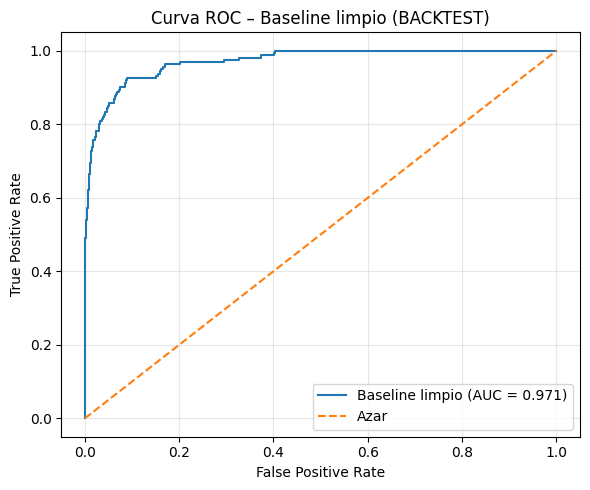

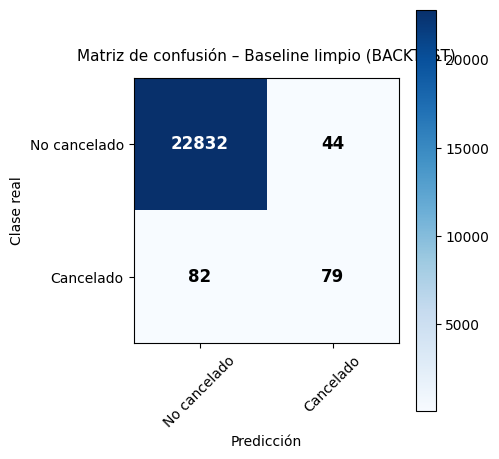

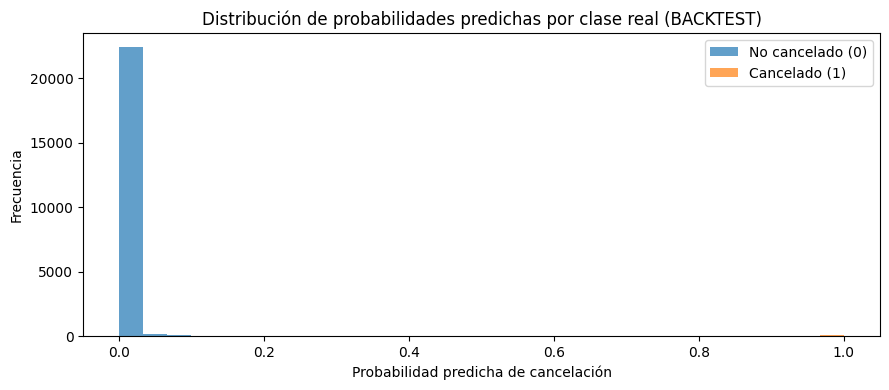

In [21]:
# BLOQUE 12 (Sprint 2)
# Visualizaciones del baseline limpio

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

print("Generando gráficos del baseline limpio (BACKTEST)...")

# Probabilidades para clase 1 (cancelado)
y_proba_bt = clf.predict_proba(X_backtest)[:, 1]

# ---------- 12.1 Curva ROC ----------
fpr, tpr, thresholds = roc_curve(y_backtest, y_proba_bt)
auc = roc_auc_score(y_backtest, y_proba_bt)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Baseline limpio (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], "--", label="Azar")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC – Baseline limpio (BACKTEST)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# ---------- 12.2 Matriz de confusión visual ----------
cm = confusion_matrix(y_backtest, clf.predict(X_backtest))

plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Matriz de confusión – Baseline limpio (BACKTEST)", fontsize=11, pad=12)
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ["No cancelado", "Cancelado"], rotation=45)
plt.yticks(tick_marks, ["No cancelado", "Cancelado"])

# texto por celda
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, format(cm[i, j], "d"),
            ha="center", va="center",
            fontsize=12,
            fontweight="bold",
            color="white" if cm[i, j] > cm.max()/2 else "black"
        )

plt.ylabel("Clase real")
plt.xlabel("Predicción")
plt.tight_layout()
plt.show()


# ---------- 12.3 Distribución de probabilidades ----------
proba_pos = y_proba_bt[y_backtest == 1]
proba_neg = y_proba_bt[y_backtest == 0]

plt.figure(figsize=(9,4))
plt.hist(proba_neg, bins=30, alpha=0.7, label="No cancelado (0)")
plt.hist(proba_pos, bins=30, alpha=0.7, label="Cancelado (1)")

plt.xlabel("Probabilidad predicha de cancelación")
plt.ylabel("Frecuencia")
plt.title("Distribución de probabilidades predichas por clase real (BACKTEST)")
plt.legend()
plt.tight_layout()
plt.show()


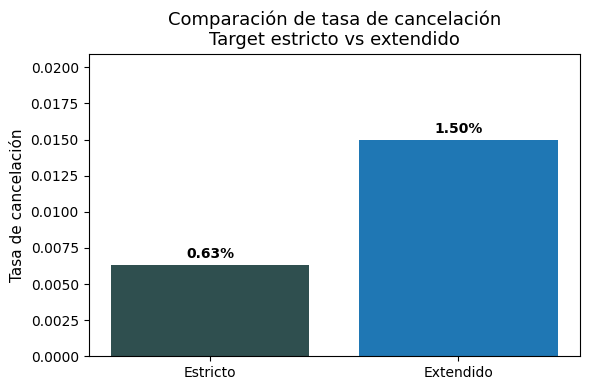

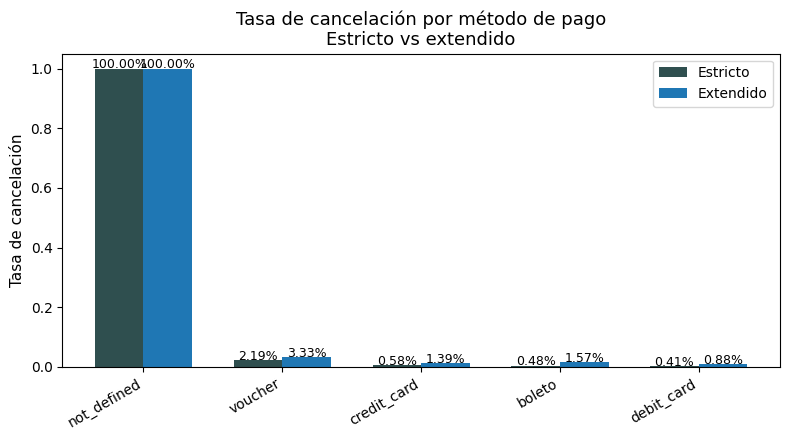

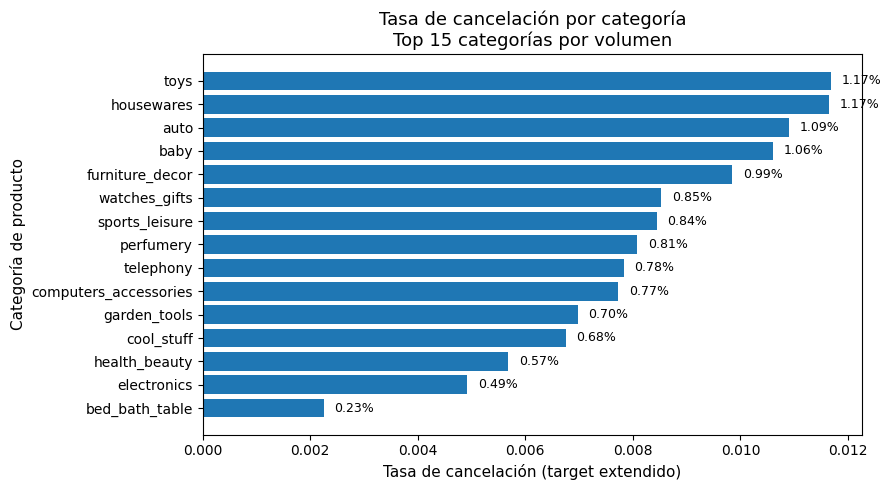

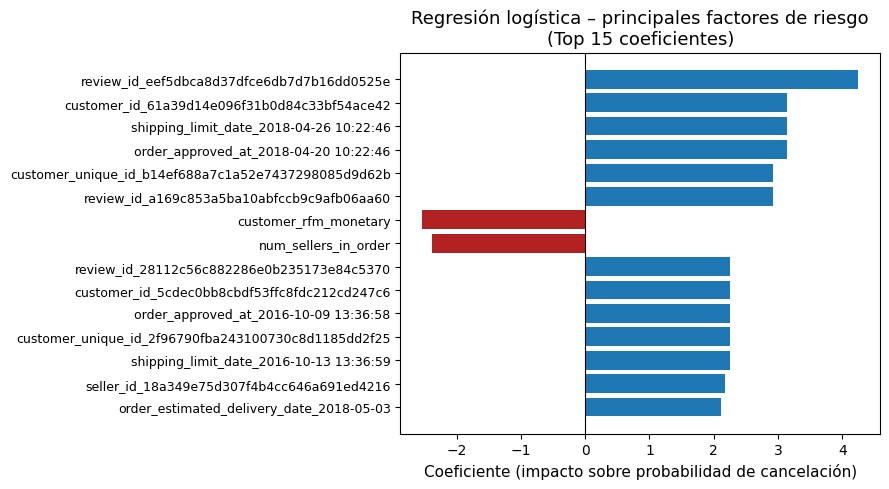

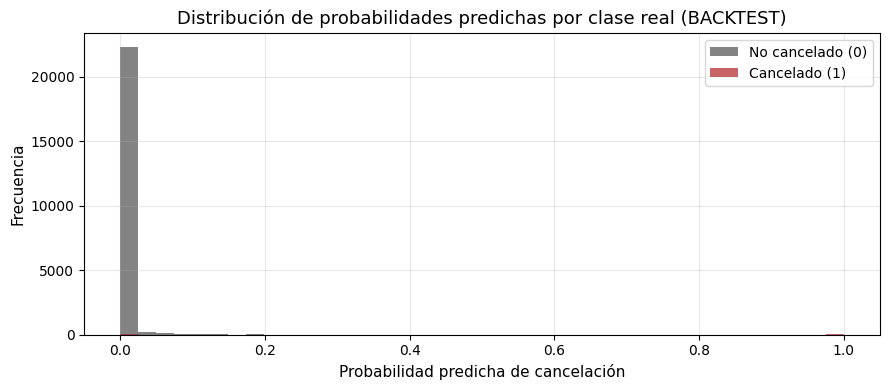

In [22]:
# BLOQUE 12.4 (Sprint 2)
# Gráficos EDA + Interpretación del baseline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Usamos df_master (dataset maestro)
df_g = df_master.copy()

# 1) Comparación Estricto vs Extendido (tasas globales)
strict_rate = df_g["is_canceled_strict"].mean()
ext_rate = df_g["order_canceled_extended"].mean()

plt.figure(figsize=(6,4))
bars = plt.bar(["Estricto", "Extendido"], [strict_rate, ext_rate], color=["#2F4F4F", "#1F77B4"])
plt.ylabel("Tasa de cancelación", fontsize=11)
plt.title("Comparación de tasa de cancelación\nTarget estricto vs extendido", fontsize=13)
plt.ylim(0, max(strict_rate, ext_rate)*1.4)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.0003, f"{height:.2%}",
             ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

# 2) Tasa por método de pago (estricto vs extendido)
if "main_payment_type" in df_g.columns:
    strict_by_pay = df_g.groupby("main_payment_type")["is_canceled_strict"].mean().sort_values(ascending=False)
    ext_by_pay = df_g.groupby("main_payment_type")["order_canceled_extended"].mean().reindex(strict_by_pay.index)

    labels = strict_by_pay.index.tolist()
    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(8,4.5))
    plt.bar(x - width/2, strict_by_pay.values, width, label="Estricto", color="#2F4F4F")
    plt.bar(x + width/2, ext_by_pay.values, width, label="Extendido", color="#1F77B4")

    plt.xticks(x, labels, rotation=30, ha="right", fontsize=10)
    plt.ylabel("Tasa de cancelación", fontsize=11)
    plt.title("Tasa de cancelación por método de pago\nEstricto vs extendido", fontsize=13)
    plt.legend()

    # etiquetas %
    for i, v in enumerate(strict_by_pay.values):
        plt.text(i - width/2, v + 0.0003, f"{v:.2%}", ha="center", fontsize=9)
    for i, v in enumerate(ext_by_pay.values):
        plt.text(i + width/2, v + 0.0003, f"{v:.2%}", ha="center", fontsize=9)

    plt.tight_layout()
    plt.show()
else:
    print("No existe main_payment_type en el dataset maestro.")


# 3) Tasa por categoría (Top 15 por volumen) – target extendido
cat_col = "product_category_name_english" if "product_category_name_english" in df_g.columns else "product_category_name"

cat_stats = (
    df_g.groupby(cat_col)["order_canceled_extended"]
    .agg(cancel_rate="mean", n_orders="count")
    .reset_index()
)

top_cats = (
    cat_stats.sort_values("n_orders", ascending=False)
    .head(15)
    .sort_values("cancel_rate", ascending=True)
)

plt.figure(figsize=(9,5))
plt.barh(top_cats[cat_col].astype(str), top_cats["cancel_rate"], color="#1F77B4")

plt.xlabel("Tasa de cancelación (target extendido)", fontsize=11)
plt.ylabel("Categoría de producto", fontsize=11)
plt.title("Tasa de cancelación por categoría\nTop 15 categorías por volumen", fontsize=13)

for i, v in enumerate(top_cats["cancel_rate"]):
    plt.text(v + 0.0002, i, f"{v:.2%}", va="center", fontsize=9)

plt.tight_layout()
plt.show()

# 4) Top 15 coeficientes del modelo (Regresión logística limpia)
model_lr = clf.named_steps["model"]
preproc_lr = clf.named_steps["preprocessor"]

# nombres numéricos
num_features_out = numeric_cols

# nombres categóricos (after onehot)
cat_transformer = preproc_lr.named_transformers_["cat"]
ohe = cat_transformer.named_steps["onehot"]
cat_features_out = ohe.get_feature_names_out(categorical_cols)

feature_names = np.concatenate([num_features_out, cat_features_out])
coefs = model_lr.coef_.ravel()

abs_coefs = np.abs(coefs)
idx_sorted = np.argsort(abs_coefs)[-15:]

top_features = feature_names[idx_sorted]
top_coefs = coefs[idx_sorted]

plt.figure(figsize=(9,5))
y_pos = np.arange(len(top_features))

colors = ["#1F77B4" if c > 0 else "#B22222" for c in top_coefs]
plt.barh(y_pos, top_coefs, color=colors)
plt.yticks(y_pos, top_features, fontsize=9)
plt.xlabel("Coeficiente (impacto sobre probabilidad de cancelación)", fontsize=11)
plt.title("Regresión logística – principales factores de riesgo\n(Top 15 coeficientes)", fontsize=13)
plt.axvline(0, color="black", linewidth=0.8)

plt.tight_layout()
plt.show()

# 5) Distribución de probabilidades predichas (BACKTEST)
y_proba_bt = clf.predict_proba(X_backtest)[:, 1]

proba_pos = y_proba_bt[y_backtest == 1]
proba_neg = y_proba_bt[y_backtest == 0]

plt.figure(figsize=(9,4))
plt.hist(proba_neg, bins=40, alpha=0.7, label="No cancelado (0)", color="#4F4F4F")
plt.hist(proba_pos, bins=40, alpha=0.7, label="Cancelado (1)", color="#B22222")

plt.xlabel("Probabilidad predicha de cancelación", fontsize=11)
plt.ylabel("Frecuencia", fontsize=11)
plt.title("Distribución de probabilidades predichas por clase real (BACKTEST)", fontsize=13)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [23]:
# =========================================
# SPRINT 3 - BLOQUE 1
# Reinicio total: cargar master + limpiar leakage + splits + limpiar inf

from google.colab import drive
import os
import pandas as pd
import numpy as np

# 1) Montar Drive (si ya está montado no pasa nada)
drive.mount("/content/drive")

# 2) Buscar automáticamente el archivo master en MyDrive
TARGET_FILE = "orders_extended_master.csv"
base_drive = "."

master_path = None
for root, dirs, files in os.walk(base_drive):
    if TARGET_FILE in files:
        master_path = os.path.join(root, TARGET_FILE)
        break

if master_path is None:
    raise FileNotFoundError(
        f"No se encontró {TARGET_FILE} en tu MyDrive. "
        "Verifica que exista y que esté dentro de alguna carpeta de MyDrive."
    )

print("Master encontrado en:", master_path)

# 3) Cargar master
df_master = pd.read_csv(master_path, parse_dates=["order_purchase_timestamp"])
print("Shape df_master:", df_master.shape)

# 4) Eliminar leakage (columnas prohibidas)
leakage_cols = [
    "order_delivered_customer_date",
    "order_delivered_carrier_date",
    "review_creation_date",
    "review_answer_timestamp",
    "review_score",
    "review_comment_message",
    "has_review_comment",
    "review_comment_length",
    "review_creation_delay_days",
    "review_answer_delay_days",
    "seller_cancel_rate_avg",
    "customer_cancellation_history"
]
leakage_cols = [c for c in leakage_cols if c in df_master.columns]

df_clean = df_master.drop(columns=leakage_cols).copy()
print("Leakage removido. Columnas quitadas:", leakage_cols)

# 5) Definir target
TARGET = "order_canceled_extended"

# 6) Split temporal docente
df_clean["purchase_ym"] = (
    df_clean["order_purchase_timestamp"]
    .dt.to_period("M").astype(str).str.replace("-", "")
)

train_months = [
    "201610","201611","201612",
    "201701","201702","201703","201704","201705","201706",
    "201707","201708","201709","201710","201711","201712",
    "201801","201802","201803","201804"
]
backtest_months = ["201805","201806","201807"]
final_test_month = ["201808"]

df_train = df_clean[df_clean["purchase_ym"].isin(train_months)]
df_backtest = df_clean[df_clean["purchase_ym"].isin(backtest_months)]
df_final_test = df_clean[df_clean["purchase_ym"].isin(final_test_month)]

features_drop = [
    "order_id",
    "order_status",
    "order_purchase_timestamp",
    "is_canceled_strict",
    TARGET,
    "purchase_ym"
]

X_train = df_train.drop(columns=features_drop)
y_train = df_train[TARGET].astype(int)

X_backtest = df_backtest.drop(columns=features_drop)
y_backtest = df_backtest[TARGET].astype(int)

X_final_test = df_final_test.drop(columns=features_drop)
y_final_test = df_final_test[TARGET].astype(int)  # no tocar hasta el final

# 7) Limpieza de infinitos
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_backtest = X_backtest.replace([np.inf, -np.inf], np.nan)
X_final_test = X_final_test.replace([np.inf, -np.inf], np.nan)

print("\nSplits listos para Sprint 3:")
print("Train:", X_train.shape, y_train.shape)
print("Backtest:", X_backtest.shape, y_backtest.shape)
print("Final Test:", X_final_test.shape, y_final_test.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Master encontrado en: ./orders_extended_master.csv
Shape df_master: (119143, 116)
Leakage removido. Columnas quitadas: ['order_delivered_customer_date', 'order_delivered_carrier_date', 'review_creation_date', 'review_answer_timestamp', 'review_score', 'review_comment_message', 'has_review_comment', 'review_comment_length', 'review_creation_delay_days', 'review_answer_delay_days', 'seller_cancel_rate_avg', 'customer_cancellation_history']

Splits listos para Sprint 3:
Train: (88555, 99) (88555,)
Backtest: (23037, 99) (23037,)
Final Test: (7524, 99) (7524,)


In [24]:
# SPRINT 3 - BLOQUE 2
# Modelo no lineal baseline (Random Forest)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

print("Entrenando modelo no lineal (Random Forest baseline)...")

# 1) Detectar columnas numéricas y categóricas
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

print(f"Detectadas {len(numeric_cols)} columnas numéricas y {len(categorical_cols)} categóricas.")

# 2) Preprocesador (mismo esquema que LR limpia)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# 3) Definir RandomForest baseline
rf_clf = Pipeline(steps=[
    ("preprocessor", preprocessor_rf),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=4,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

# 4) Entrenar RF
rf_clf.fit(X_train, y_train)
print("Random Forest entrenado.")

# 5) Evaluación en BACKTEST
y_pred_rf = rf_clf.predict(X_backtest)
y_proba_rf = rf_clf.predict_proba(X_backtest)[:, 1]

acc = accuracy_score(y_backtest, y_pred_rf)
prec = precision_score(y_backtest, y_pred_rf, zero_division=0)
rec = recall_score(y_backtest, y_pred_rf, zero_division=0)
f1 = f1_score(y_backtest, y_pred_rf, zero_division=0)
auc = roc_auc_score(y_backtest, y_proba_rf)
gini = 2 * auc - 1

print("\nMÉTRICAS BACKTEST – Random Forest")
print("--------------------------------------")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC-ROC  : {auc:.4f}")
print(f"Gini     : {gini:.4f}")

# 6) Matriz de confusión
print("\nMatriz de confusión:")
print(confusion_matrix(y_backtest, y_pred_rf))

# 7) Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_backtest, y_pred_rf, digits=4))


Entrenando modelo no lineal (Random Forest baseline)...
Detectadas 82 columnas numéricas y 17 categóricas.
Random Forest entrenado.

MÉTRICAS BACKTEST – Random Forest
--------------------------------------
Accuracy : 0.9954
Precision: 1.0000
Recall   : 0.3354
F1-score : 0.5023
AUC-ROC  : 0.9224
Gini     : 0.8448

Matriz de confusión:
[[22876     0]
 [  107    54]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9953    1.0000    0.9977     22876
           1     1.0000    0.3354    0.5023       161

    accuracy                         0.9954     23037
   macro avg     0.9977    0.6677    0.7500     23037
weighted avg     0.9954    0.9954    0.9942     23037



In [25]:
import xgboost as xgb
print("XGBoost cargado OK")


XGBoost cargado OK


In [26]:
# SPRINT 3 - BLOQUE 3
# Modelo Avanzado: XGBoost Baseline

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

print("Entrenando modelo avanzado (XGBoost baseline)...")

# 1) Columnas numéricas y categóricas
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

# 2) Preprocesador
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_xgb = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# 3) Definir modelo XGBoost baseline
xgb_clf = Pipeline(steps=[
    ("preprocessor", preprocessor_xgb),
    ("model", XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.08,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss"
    ))
])

# 4) Entrenar
xgb_clf.fit(X_train, y_train)
print("XGBoost entrenado correctamente.")

# 5) Evaluación en BACKTEST
y_pred_xgb = xgb_clf.predict(X_backtest)
y_proba_xgb = xgb_clf.predict_proba(X_backtest)[:, 1]

acc = accuracy_score(y_backtest, y_pred_xgb)
prec = precision_score(y_backtest, y_pred_xgb, zero_division=0)
rec = recall_score(y_backtest, y_pred_xgb, zero_division=0)
f1 = f1_score(y_backtest, y_pred_xgb, zero_division=0)
auc = roc_auc_score(y_backtest, y_proba_xgb)
gini = 2 * auc - 1

print("\nMÉTRICAS BACKTEST – XGBoost Baseline")
print("-----------------------------------------")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC-ROC  : {auc:.4f}")
print(f"Gini     : {gini:.4f}")

# 6) Matriz de confusión
print("\nMatriz de confusión:")
print(confusion_matrix(y_backtest, y_pred_xgb))

# 7) Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_backtest, y_pred_xgb, digits=4))


Entrenando modelo avanzado (XGBoost baseline)...
XGBoost entrenado correctamente.

MÉTRICAS BACKTEST – XGBoost Baseline
-----------------------------------------
Accuracy : 0.9951
Precision: 0.6738
Recall   : 0.5901
F1-score : 0.6291
AUC-ROC  : 0.9781
Gini     : 0.9562

Matriz de confusión:
[[22830    46]
 [   66    95]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9971    0.9980    0.9976     22876
           1     0.6738    0.5901    0.6291       161

    accuracy                         0.9951     23037
   macro avg     0.8354    0.7940    0.8133     23037
weighted avg     0.9949    0.9951    0.9950     23037



In [6]:
# SPRINT 3 - BLOQUE 4 (VERSIÓN RÁPIDA)
# Tuning XGBoost optimizado para RECALL en Colab

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import numpy as np

print("🔍 Tuning rápido del XGBoost (prioridad: RECALL)...")

# Columnas
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

# Preprocesamiento
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_xgb = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Modelo base
base_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    random_state=42,
    n_jobs=-1
)

# Espacio reducido (rápido)
param_grid = {
    "model__n_estimators": [150, 250, 350],
    "model__max_depth": [4, 5, 6],
    "model__learning_rate": [0.05, 0.08],
    "model__subsample": [0.7, 0.85],
    "model__colsample_bytree": [0.7, 0.85],
}

# Pipeline + RS
pipeline_tuning = Pipeline(steps=[
    ("preprocessor", preprocessor_xgb),
    ("model", base_model)
])

random_search = RandomizedSearchCV(
    estimator=pipeline_tuning,
    param_distributions=param_grid,
    n_iter=10,           # Fast
    scoring="recall",    # Prioridad: recall
    cv=2,                # Mucho más rápido
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Ejecutar tuning
random_search.fit(X_train, y_train)

print("\nTuning rápido finalizado.")
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Guardar mejor modelo
best_xgb = random_search.best_estimator_
print("\n🏆 Modelo optimizado guardado en best_xgb.")


🔍 Tuning rápido del XGBoost (prioridad: RECALL)...
Fitting 2 folds for each of 10 candidates, totalling 20 fits

Tuning rápido finalizado.
Mejores hiperparámetros encontrados:
{'model__subsample': 0.7, 'model__n_estimators': 150, 'model__max_depth': 4, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.7}

🏆 Modelo optimizado guardado en best_xgb.


# Validacion Cruzada

In [27]:
# SPRINT 3 – BLOQUE 5
# Validación cruzada (k-fold) de los modelos (train)

from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np
import pandas as pd

print("🔁 Ejecutando validación cruzada (k-fold) sobre el set de TRAIN...")

# ---------------------------------------------------
# 1) Definir el esquema de validación cruzada
#    Usamos StratifiedKFold para mantener el balance
#    de la clase objetivo en cada fold.
# ---------------------------------------------------
cv = StratifiedKFold(
    n_splits=5,          # k = 5 folds (puedes cambiar a 3 o 10 si quieres)
    shuffle=True,
    random_state=42
)

# ---------------------------------------------------
# 2) Métricas que queremos evaluar en cada fold
# ---------------------------------------------------
scoring = {
    "roc_auc": "roc_auc",
    "f1": "f1",
    "recall": "recall",
    "precision": "precision"
}

# ---------------------------------------------------
# 3) Modelos a validar
#    Asegúrate de haber ejecutado antes:
#    - BLOQUE 10R (clf   : Regresión Logística baseline)
#    - SPRINT 3 BLOQUE 2 (rf_clf: Random Forest baseline)
#    - SPRINT 3 BLOQUE 3 (xgb_clf: XGBoost baseline)
# ---------------------------------------------------
modelos = {
    "LogReg_baseline": clf,
    "RF_baseline": rf_clf,
    "XGB_baseline": xgb_clf
    # Si quieres, también puedes agregar el modelo tunado:
    # "XGB_tunado": best_xgb
}

resultados_cv = []

for nombre, modelo in modelos.items():
    print(f"\n▶ Modelo: {nombre}")

    cv_res = cross_validate(
        modelo,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )

    fila = {
        "Modelo": nombre,
        "AUC-ROC_mean":  np.mean(cv_res["test_roc_auc"]),
        "AUC-ROC_std":   np.std(cv_res["test_roc_auc"]),
        "F1_mean":       np.mean(cv_res["test_f1"]),
        "F1_std":        np.std(cv_res["test_f1"]),
        "Recall_mean":   np.mean(cv_res["test_recall"]),
        "Recall_std":    np.std(cv_res["test_recall"]),
        "Prec_mean":     np.mean(cv_res["test_precision"]),
        "Prec_std":      np.std(cv_res["test_precision"])
    }

    resultados_cv.append(fila)

# ---------------------------------------------------
# 4) Tabla resumen de la validación cruzada
# ---------------------------------------------------
cv_df = pd.DataFrame(resultados_cv)

print("\n Resultados de validación cruzada (k-fold) en TRAIN:")
display(cv_df.round(4))


🔁 Ejecutando validación cruzada (k-fold) sobre el set de TRAIN...

▶ Modelo: LogReg_baseline

▶ Modelo: RF_baseline

▶ Modelo: XGB_baseline


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



📊 Resultados de validación cruzada (k-fold) en TRAIN:


,Modelo,AUC-ROC_mean,AUC-ROC_std,F1_mean,F1_std,Recall_mean,Recall_std,Prec_mean,Prec_std
0,LogReg_baseline,0.9914,0.0014,0.7786,0.0087,0.7971,0.0164,0.7616,0.0210
1,RF_baseline,0.9782,0.0035,0.7556,0.0201,0.6088,0.0261,0.9967,0.0027
2,XGB_baseline,0.9931,0.0007,0.7730,0.0178,0.8177,0.0141,0.7338,0.0320


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['AUC-ROC_mean'].plot(kind='hist', bins=20, title='AUC-ROC_mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['AUC-ROC_std'].plot(kind='hist', bins=20, title='AUC-ROC_std')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['F1_mean'].plot(kind='hist', bins=20, title='F1_mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Modelo').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='AUC-ROC_mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='AUC-ROC_mean', y='AUC-ROC_std', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='AUC-ROC_std', y='F1_mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='F1_mean', y='F1_std', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['AUC-ROC_mean']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Modelo')):
  _plot_series(series, series_name, i)
  fig.legend(title='Modelo', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('AUC-ROC_mean')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['AUC-ROC_std']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Modelo')):
  _plot_series(series, series_name, i)
  fig.legend(title='Modelo', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('AUC-ROC_std')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['F1_mean']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Modelo')):
  _plot_series(series, series_name, i)
  fig.legend(title='Modelo', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('F1_mean')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['F1_std']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Modelo')):
  _plot_series(series, series_name, i)
  fig.legend(title='Modelo', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('F1_std')

from matplotlib import pyplot as plt
_df_13['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['AUC-ROC_mean'].plot(kind='line', figsize=(8, 4), title='AUC-ROC_mean')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['AUC-ROC_std'].plot(kind='line', figsize=(8, 4), title='AUC-ROC_std')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['F1_mean'].plot(kind='line', figsize=(8, 4), title='F1_mean')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Modelo'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='Modelo', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Modelo'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='AUC-ROC_mean', y='Modelo', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Modelo'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='AUC-ROC_std', y='Modelo', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Modelo'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='F1_mean', y='Modelo', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# SPRINT 3 - BLOQUE 5.1
# Evaluación del modelo optimizado (best_xgb) en BACKTEST

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

print("Evaluando modelo XGBoost TUNEADO en BACKTEST...")

# Predicciones
y_pred_tuned = best_xgb.predict(X_backtest)
y_proba_tuned = best_xgb.predict_proba(X_backtest)[:, 1]

# Métricas
acc = accuracy_score(y_backtest, y_pred_tuned)
prec = precision_score(y_backtest, y_pred_tuned, zero_division=0)
rec = recall_score(y_backtest, y_pred_tuned, zero_division=0)
f1 = f1_score(y_backtest, y_pred_tuned, zero_division=0)
auc = roc_auc_score(y_backtest, y_proba_tuned)
gini = 2 * auc - 1

print("\nMÉTRICAS BACKTEST – XGBoost TUNEADO")
print("-----------------------------------------")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC-ROC  : {auc:.4f}")
print(f"Gini     : {gini:.4f}")

# Matriz de confusión
print("\nMatriz de confusión:")
print(confusion_matrix(y_backtest, y_pred_tuned))

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_backtest, y_pred_tuned, digits=4))


📊 Evaluando modelo XGBoost TUNEADO en BACKTEST...

📌 MÉTRICAS BACKTEST – XGBoost TUNEADO
-----------------------------------------
Accuracy : 0.9825
Precision: 0.2535
Recall   : 0.7764
F1-score : 0.3823
AUC-ROC  : 0.9822
Gini     : 0.9643

Matriz de confusión:
[[22508   368]
 [   36   125]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9984    0.9839    0.9911     22876
           1     0.2535    0.7764    0.3823       161

    accuracy                         0.9825     23037
   macro avg     0.6260    0.8802    0.6867     23037
weighted avg     0.9932    0.9825    0.9869     23037



In [ ]:
# SPRINT 3 - BLOQUE 6
# Evaluación del modelo optimizado (best_xgb) en FINAL TEST

print(" Evaluando modelo XGBoost TUNEADO en FINAL TEST (201808)...")

y_pred_final = best_xgb.predict(X_final_test)
y_proba_final = best_xgb.predict_proba(X_final_test)[:, 1]

acc_f = accuracy_score(y_final_test, y_pred_final)
prec_f = precision_score(y_final_test, y_pred_final, zero_division=0)
rec_f = recall_score(y_final_test, y_pred_final, zero_division=0)
f1_f = f1_score(y_final_test, y_pred_final, zero_division=0)
auc_f = roc_auc_score(y_final_test, y_proba_final)
gini_f = 2 * auc_f - 1

print("\nMÉTRICAS FINAL TEST – XGBoost TUNEADO")
print(f"Accuracy : {acc_f:.4f}")
print(f"Precision: {prec_f:.4f}")
print(f"Recall   : {rec_f:.4f}")
print(f"F1-score : {f1_f:.4f}")
print(f"AUC-ROC  : {auc_f:.4f}")
print(f"Gini     : {gini_f:.4f}")

print("\nMatriz de confusión:")
print(confusion_matrix(y_final_test, y_pred_final))

print("\nReporte de clasificación:")
print(classification_report(y_final_test, y_pred_final, digits=4))


📊 Evaluando modelo XGBoost TUNEADO en FINAL TEST (201808)...

📌 MÉTRICAS FINAL TEST – XGBoost TUNEADO
-------------------------------------------
Accuracy : 0.9887
Precision: 0.5286
Recall   : 0.7957
F1-score : 0.6352
AUC-ROC  : 0.9805
Gini     : 0.9611

Matriz de confusión:
[[7365   66]
 [  19   74]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9974    0.9911    0.9943      7431
           1     0.5286    0.7957    0.6352        93

    accuracy                         0.9887      7524
   macro avg     0.7630    0.8934    0.8147      7524
weighted avg     0.9916    0.9887    0.9898      7524



In [ ]:
# SPRINT 3 - BLOQUE 7
# Exportar modelo final entrenado

import joblib

ruta_salida = "./data/modelo_final_xgb.pkl"

joblib.dump(best_xgb, ruta_salida)

print("Modelo final exportado en:")
print(ruta_salida)


✅ Modelo final exportado en:
./data/modelo_final_xgb.pkl


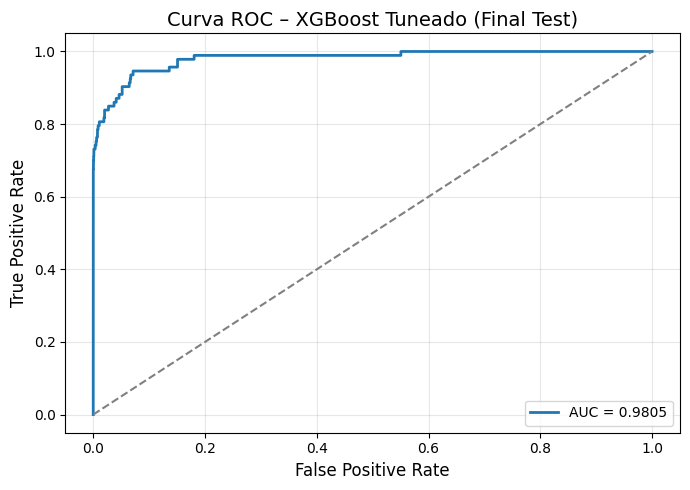

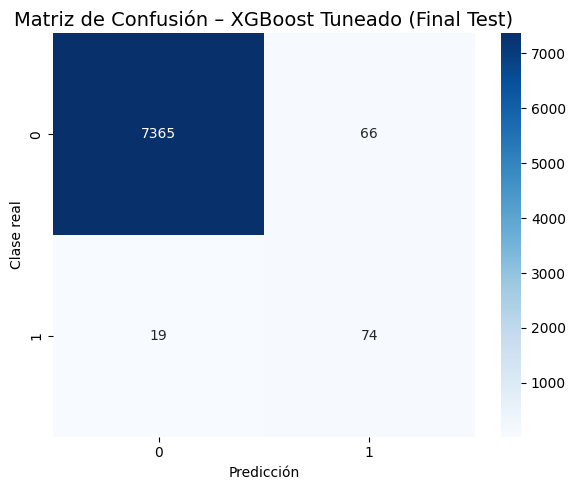

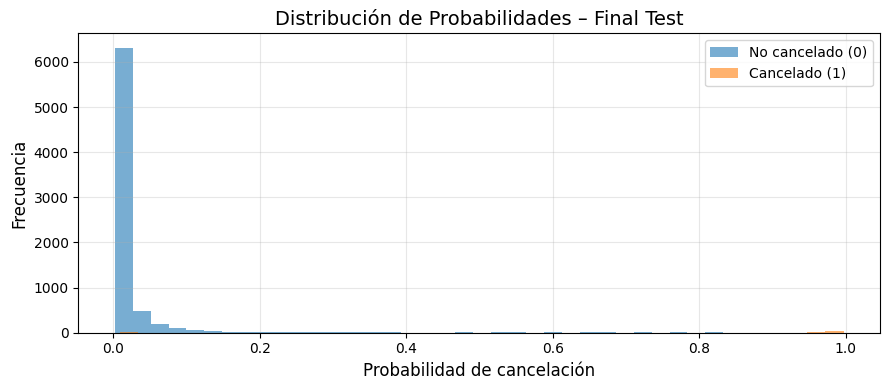

<Figure size 1000x800 with 0 Axes>

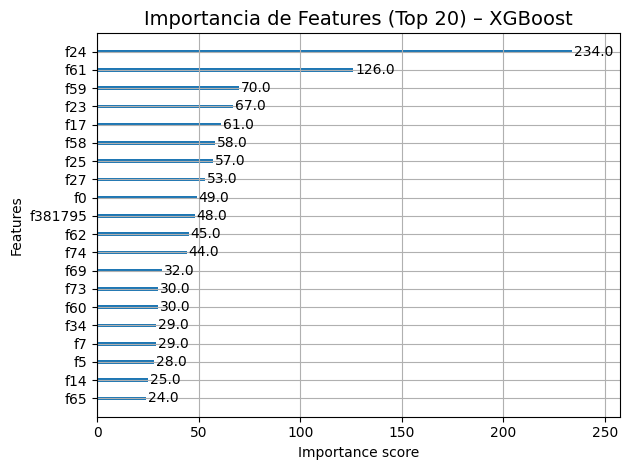

Calculando valores SHAP... (puede tardar unos segundos)


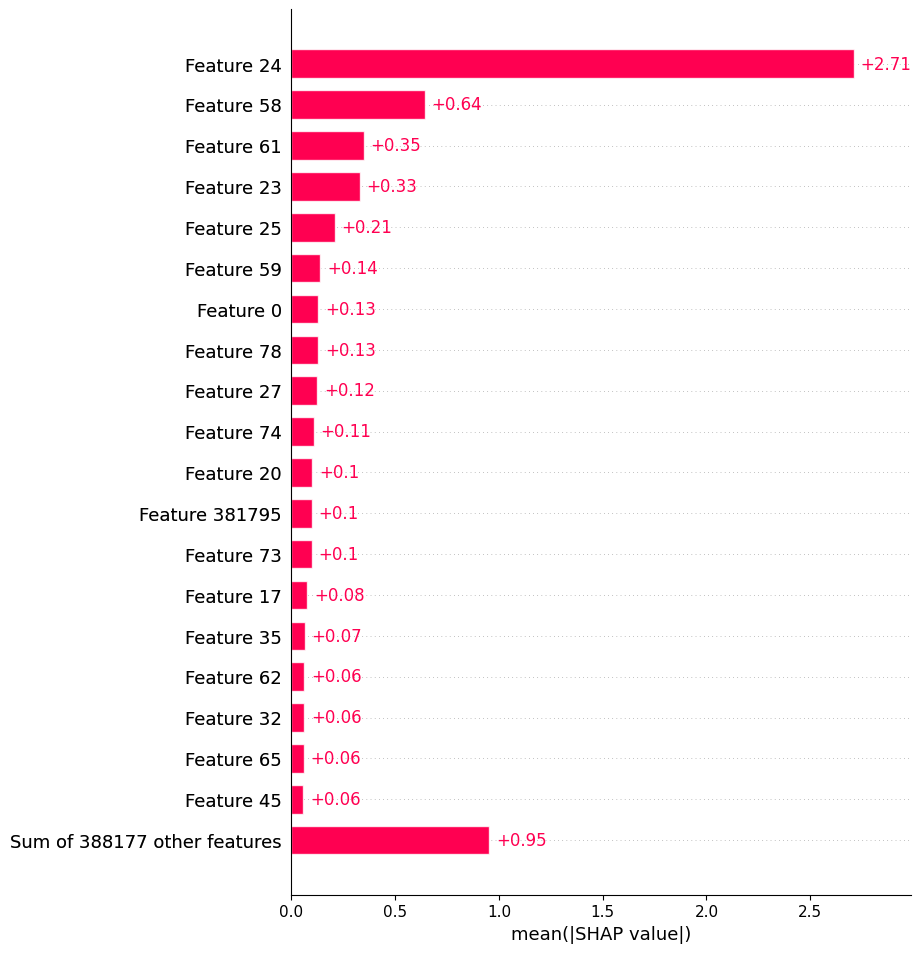

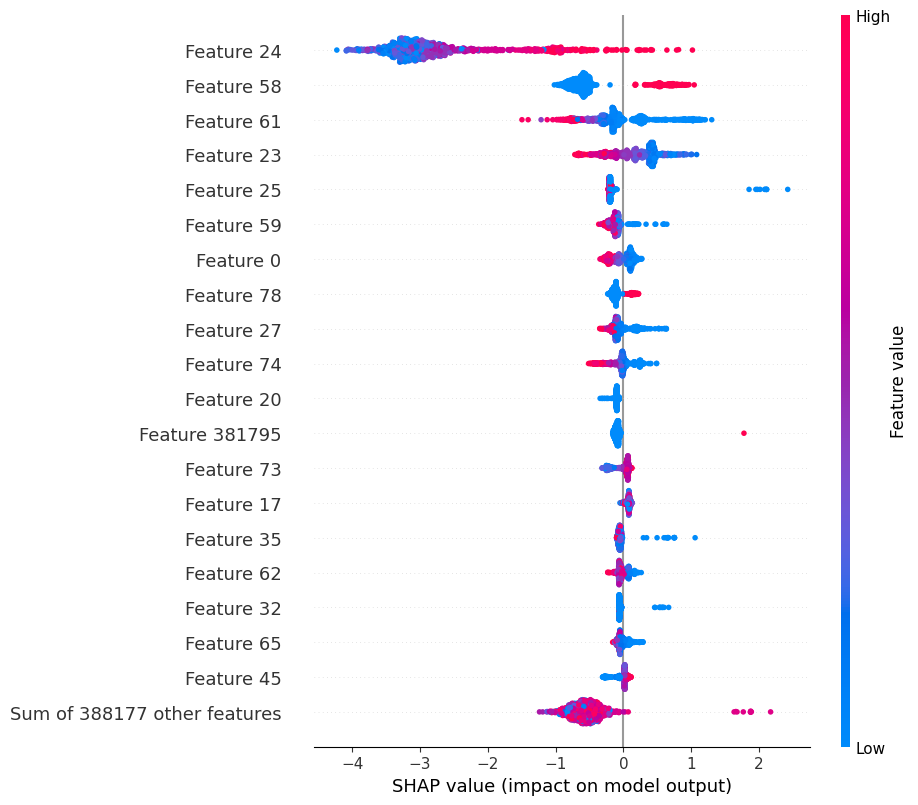

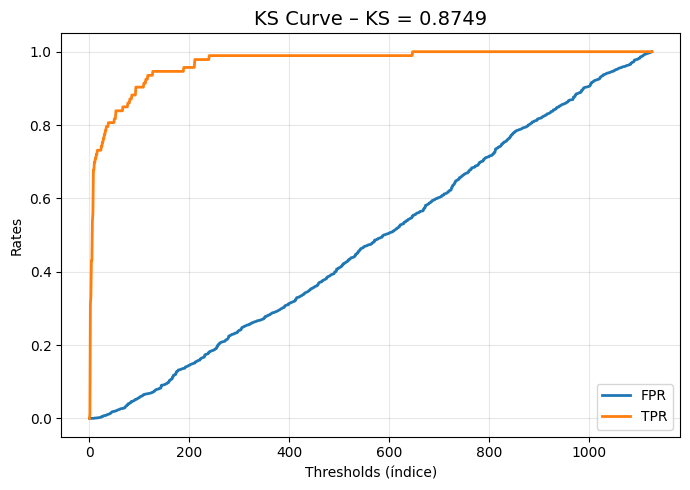

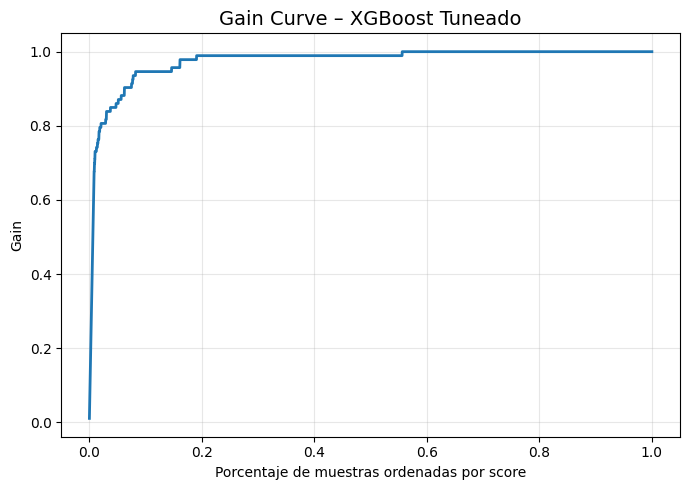

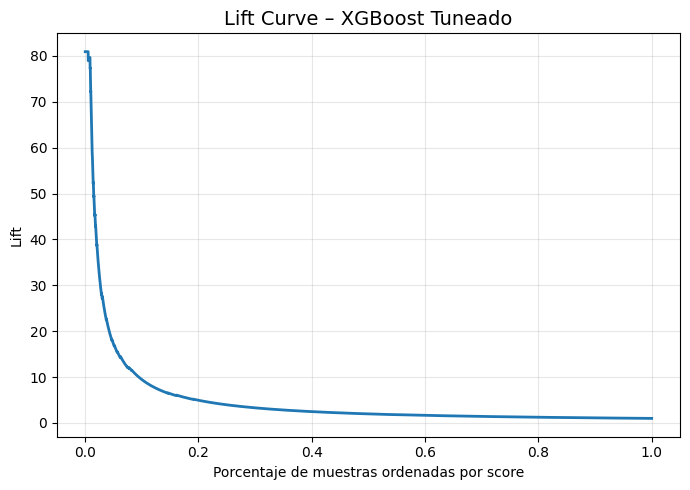

In [ ]:
# SPRINT 3 - BLOQUE 8
# Gráficos finales del modelo XGBoost tuneado

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns

# 1) CURVA ROC – FINAL TEST
fpr, tpr, _ = roc_curve(y_final_test, y_proba_final)
auc = roc_auc_score(y_final_test, y_proba_final)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", linewidth=2)
plt.plot([0,1], [0,1], "--", color="gray")
plt.title("Curva ROC – XGBoost Tuneado (Final Test)", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2) MATRIZ DE CONFUSIÓN – FINAL TEST
cm = confusion_matrix(y_final_test, y_pred_final)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión – XGBoost Tuneado (Final Test)", fontsize=14)
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.tight_layout()
plt.show()

# 3) DISTRIBUCIÓN DE PROBABILIDADES
plt.figure(figsize=(9,4))
plt.hist(y_proba_final[y_final_test==0], bins=40, alpha=0.6, label="No cancelado (0)")
plt.hist(y_proba_final[y_final_test==1], bins=40, alpha=0.6, label="Cancelado (1)")
plt.title("Distribución de Probabilidades – Final Test", fontsize=14)
plt.xlabel("Probabilidad de cancelación", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# 4) FEATURE IMPORTANCE – XGBoost NATIVO
from xgboost import plot_importance

plt.figure(figsize=(10,8))
plot_importance(best_xgb.named_steps["model"], max_num_features=20)
plt.title("Importancia de Features (Top 20) – XGBoost", fontsize=14)
plt.tight_layout()
plt.show()


# 5) FEATURE IMPORTANCE – SHAP

import shap

print("Calculando valores SHAP... (puede tardar unos segundos)")

# Construir el SHAP explainer con solo el modelo XGB
xgb_model_only = best_xgb.named_steps["model"]

# Tomamos una muestra de 1000 filas para acelerar
sample = X_final_test.sample(1000, random_state=42)

# Aplicamos el preprocesador a la muestra
sample_transformed = best_xgb.named_steps["preprocessor"].transform(sample)

explainer = shap.TreeExplainer(xgb_model_only)
shap_values = explainer(sample_transformed)

# Gráfico SHAP de barras
shap.plots.bar(shap_values, max_display=20)


# Beeswarm plot
shap.plots.beeswarm(shap_values, max_display=20)

# 6) KS CURVE – FINAL TEST
from sklearn.metrics import roc_curve

def ks_curve(y_true, y_probs):
    fpr, tpr, thr = roc_curve(y_true, y_probs)
    ks = max(tpr - fpr)
    return fpr, tpr, ks

fpr, tpr, ks = ks_curve(y_final_test, y_proba_final)

plt.figure(figsize=(7,5))
plt.plot(fpr, label="FPR", linewidth=2)
plt.plot(tpr, label="TPR", linewidth=2)
plt.title(f"KS Curve – KS = {ks:.4f}", fontsize=14)
plt.xlabel("Thresholds (índice)")
plt.ylabel("Rates")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 7) GAIN & LIFT CURVES
from sklearn.metrics import roc_auc_score

def gain_lift_curve(y_true, y_scores):
    df = pd.DataFrame({"y": y_true, "score": y_scores})
    df = df.sort_values("score", ascending=False)
    df["cum_positive"] = df["y"].cumsum()
    df["cum_total"] = np.arange(1, len(df)+1)
    df["gain"] = df["cum_positive"] / df["y"].sum()
    df["lift"] = df["gain"] / (df["cum_total"] / len(df))
    return df

df_gl = gain_lift_curve(y_final_test, y_proba_final)

# Gain Curve
plt.figure(figsize=(7,5))
plt.plot(df_gl["cum_total"]/len(df_gl), df_gl["gain"], linewidth=2)
plt.title("Gain Curve – XGBoost Tuneado", fontsize=14)
plt.xlabel("Porcentaje de muestras ordenadas por score")
plt.ylabel("Gain")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Lift Curve
plt.figure(figsize=(7,5))
plt.plot(df_gl["cum_total"]/len(df_gl), df_gl["lift"], linewidth=2)
plt.title("Lift Curve – XGBoost Tuneado", fontsize=14)
plt.xlabel("Porcentaje de muestras ordenadas por score")
plt.ylabel("Lift")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Generación de todas las figuras Sprint 3 en PNG

import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np
import pandas as pd
from xgboost import plot_importance
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# Crear carpeta donde se guardarán las gráficas
fig_path = "./data/figuras_sprint3/"
os.makedirs(fig_path, exist_ok=True)

print("Carpeta creada para las gráficas:", fig_path)

# 1. ROC - Final Test
fpr, tpr, _ = roc_curve(y_final_test, y_proba_final)
auc = roc_auc_score(y_final_test, y_proba_final)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", linewidth=2)
plt.plot([0,1], [0,1], "--", color="gray")
plt.title("Curva ROC – XGBoost Tuneado (Final Test)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(alpha=0.3)
plt.legend()
plt.savefig(fig_path + "roc_finaltest.png", dpi=300, bbox_inches="tight")
plt.close()

# 2. Matriz de Confusión - Final Test
cm = confusion_matrix(y_final_test, y_pred_final)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión – Final Test")
plt.xlabel("Predicción")
plt.ylabel("Clase Real")
plt.savefig(fig_path + "confusion_finaltest.png", dpi=300, bbox_inches="tight")
plt.close()

# 3. Distribución de Probabilidades
plt.figure(figsize=(9,4))
plt.hist(y_proba_final[y_final_test == 0], bins=40, alpha=0.6, label="No cancelado (0)")
plt.hist(y_proba_final[y_final_test == 1], bins=40, alpha=0.6, label="Cancelado (1)")
plt.title("Distribución de Probabilidades – Final Test")
plt.xlabel("Probabilidad de cancelación")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(fig_path + "prob_dist_finaltest.png", dpi=300, bbox_inches="tight")
plt.close()

# 4. Importancia XGBoost
plt.figure(figsize=(10,8))
plot_importance(best_xgb.named_steps["model"], max_num_features=20)
plt.title("Importancia de Features (Top 20) – XGBoost")
plt.savefig(fig_path + "xgb_importance.png", dpi=300, bbox_inches="tight")
plt.close()

# 5. SHAP – Bar Plot & Beeswarm
# Preprocesador + modelo
xgb_model = best_xgb.named_steps["model"]
preprocess = best_xgb.named_steps["preprocessor"]

sample = X_final_test.sample(800, random_state=42)
sample_transformed = preprocess.transform(sample)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(sample_transformed)

# Bar plot
shap.plots.bar(shap_values, max_display=20, show=False)
plt.savefig(fig_path + "shap_bar.png", dpi=300, bbox_inches="tight")
plt.close()

# Beeswarm
shap.plots.beeswarm(shap_values, max_display=20, show=False)
plt.savefig(fig_path + "shap_beeswarm.png", dpi=300, bbox_inches="tight")
plt.close()

# 6. KS Curve
def ks_curve(y_true, y_probs):
    fpr, tpr, thr = roc_curve(y_true, y_probs)
    ks = max(tpr - fpr)
    return fpr, tpr, ks

fpr, tpr, ks = ks_curve(y_final_test, y_proba_final)

plt.figure(figsize=(7,5))
plt.plot(fpr, label="FPR", linewidth=2)
plt.plot(tpr, label="TPR", linewidth=2)
plt.title(f"KS Curve – KS = {ks:.4f}")
plt.xlabel("Índice")
plt.ylabel("Tasa")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(fig_path + "ks_curve.png", dpi=300, bbox_inches="tight")
plt.close()

# 7. Gain & Lift Curves
def gain_lift_curve(y_true, y_scores):
    df = pd.DataFrame({"y": y_true, "score": y_scores})
    df = df.sort_values("score", ascending=False)
    df["cum_positive"] = df["y"].cumsum()
    df["cum_total"] = np.arange(1, len(df)+1)
    df["gain"] = df["cum_positive"] / df["y"].sum()
    df["lift"] = df["gain"] / (df["cum_total"] / len(df))
    return df

df_gl = gain_lift_curve(y_final_test, y_proba_final)

# Gain curve
plt.figure(figsize=(7,5))
plt.plot(df_gl["cum_total"]/len(df_gl), df_gl["gain"], linewidth=2)
plt.title("Gain Curve – XGBoost")
plt.xlabel("Porcentaje de población")
plt.ylabel("Gain")
plt.grid(alpha=0.3)
plt.savefig(fig_path + "gain_curve.png", dpi=300, bbox_inches="tight")
plt.close()

# Lift curve
plt.figure(figsize=(7,5))
plt.plot(df_gl["cum_total"]/len(df_gl), df_gl["lift"], linewidth=2)
plt.title("Lift Curve – XGBoost")
plt.xlabel("Porcentaje de población")
plt.ylabel("Lift")
plt.grid(alpha=0.3)
plt.savefig(fig_path + "lift_curve.png", dpi=300, bbox_inches="tight")
plt.close()

print("Todas las imágenes fueron guardadas en:")
print(fig_path)


📁 Carpeta creada para las gráficas: ./data/figuras_sprint3/
🎉 Todas las imágenes fueron guardadas en:
./data/figuras_sprint3/
